<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/Stock_Price_Predictor_Using_LSTM%2C_Bidirectional%2C_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
from datetime import datetime

## Load data
We predict the stock price of apple here. If we want to predict other stocks, we can simply change the symbol.

In [79]:
symbol = 'AAPL'
end = datetime.now()
start = datetime(2012, end.month, end.day)
stock_data = DataReader(symbol, 'yahoo', start, end)

In [80]:
stock_data.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-05,126.160004,123.070000,123.870003,125.900002,88651200.0,125.900002
2021-04-06,127.129997,125.650002,126.500000,126.209999,80171300.0,126.209999
2021-04-07,127.919998,125.139999,125.830002,127.900002,83466700.0,127.900002
2021-04-08,130.389999,128.520004,128.949997,130.360001,88844600.0,130.360001
2021-04-09,133.039993,129.470001,129.800003,133.000000,106513800.0,133.000000
2021-04-12,132.850006,130.630005,132.520004,131.240005,91420000.0,131.240005
2021-04-13,134.660004,131.929993,132.440002,134.429993,91266500.0,134.429993
2021-04-14,135.000000,131.660004,134.940002,132.029999,87222800.0,132.029999
2021-04-15,135.000000,133.639999,133.820007,134.500000,89347100.0,134.500000


In [81]:
# Create a new dataframe with only the 'Close column 
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2151

In [96]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.301013  ],
       [0.27212921],
       [0.25214554],
       ...,
       [4.56931394],
       [4.66489297],
       [4.65173649]])

In [97]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [98]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [99]:
x_train.shape

(2091, 60, 1)

## Build the model

In [104]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Conv1D, Dropout, Bidirectional, InputLayer
model = Sequential([
  tf.keras.layers.InputLayer((x_train.shape[1], 1)),
  Bidirectional(LSTM(128, return_sequences=True)),
  Conv1D(32, 1),
  Flatten(),
  Dense(32),
  Dropout(0.3),
  Dense(1)
])
loss = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer='adam', loss=loss)
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 60, 256)           133120    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 60, 32)            8224      
_________________________________________________________________
flatten_25 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                61472     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 33        
Total params: 202,849
Trainable params: 202,849
Non-trainable params: 0
_______________________________________________

## Train the model

In [108]:
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2091/2091 [==============================] - 11s 5ms/step - loss: 0.0911
Epoch 2/5
2091/2091 [==============================] - 11s 5ms/step - loss: 0.0829
Epoch 3/5
2091/2091 [==============================] - 11s 5ms/step - loss: 0.0867
Epoch 4/5
2091/2091 [==============================] - 11s 5ms/step - loss: 0.0784
Epoch 5/5
2091/2091 [==============================] - 11s 5ms/step - loss: 0.0803


## Predict data

In [109]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

11.027577655998062

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


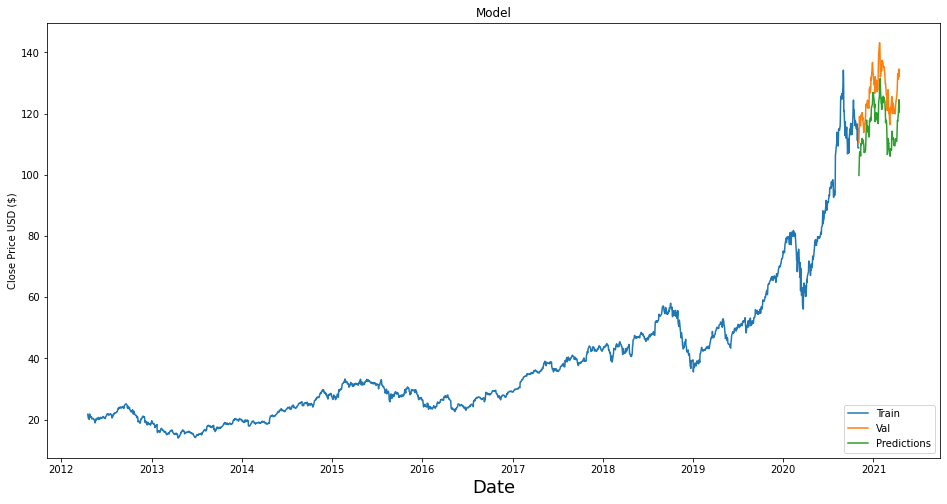

In [111]:
train = data[:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()